# Cumulative kymograph maker (per expt)
This notebook is for generating summed kymographs over a single expt.

In [1]:
import btrack
print("version no.:", btrack.__version__)
from btrack.utils import import_HDF, import_JSON
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import timeit ## can remove after assessing speed of different methods
from tqdm import tqdm

version no.: 0.4.0


In [191]:
def euclidean_distance(target_track, other_track, frame):
    try:
        idx0 = target_track.t.index(find_apoptosis_time(target_track, index = False)) ## could also do just ## apop_index
        idx1 = other_track.t.index(frame) ## t.index provides the index of that frame
    except:
        return np.inf
    
    dx = target_track.x[idx0] - other_track.x[idx1]
    dy = target_track.y[idx0] - other_track.y[idx1]
    
    return np.sqrt(dx**2 + dy**2)

def euc_dist(target_track, other_track, frame, apop_index):
    try:
        idx0 = apop_index ##target_track.t.index(apop_time) ## could also do just ## apop_index
        idx1 = other_track.t.index(frame) ## t.index provides the index of that frame
    except:
        return np.inf
    
    dx = target_track.x[idx0] - other_track.x[idx1]
    dy = target_track.y[idx0] - other_track.y[idx1]
    
    return np.sqrt(dx**2 + dy**2)

def euc_dist_mito(target_track, other_track, apop_index):
    idx0 = apop_index ##target_track.t.index(apop_time) ## could also do just ## apop_index
    idx1 = -1 ## t[-1] is the final frame, ie the frame of mitosis
    
    dx = target_track.x[idx0] - other_track.x[idx1]
    dy = target_track.y[idx0] - other_track.y[idx1]
    
    return np.sqrt(dx**2 + dy**2)

def find_apoptosis_time(target_track, index): ### if index is set to True then the index of the apoptotic time (wrt target_track) is returned
    try:
        if target_track.label[0] == 'APOPTOSIS': ## if the first classification is apoptosis then thats a duff track
            print("False apoptosis Scr ID:", target_track.ID)
            apop_index = apop_time = False
            if index == True: 
                return apop_index
            else: 
                return apop_time
        else: 
            for i, j in enumerate(target_track.label):
                if j == 'APOPTOSIS' and target_track.label[i+1] == 'APOPTOSIS' and target_track.label[i+2] == 'APOPTOSIS': # and target_track.label[i+3] =='APOPTOSIS' and target_track.label[i+4] =='APOPTOSIS':
                    apop_index = i
                    break
            apop_time = target_track.t[apop_index]
            if index == True: 
                return apop_index
            else: 
                return apop_time
    except: 
        print("False apoptosis Scr ID:", target_track.ID)
        apop_index = apop_time = False
        if index == True: 
            return apop_index
        else: 
            return apop_time
        
def kymo_labels(num_bins, label_freq):
    radial_bin = radius / num_bins
    temporal_bin = t_range*2 / num_bins

    ### generate labels for axis PIXELS/FRAMES
    xlocs = range(0, num_bins,label_freq) ## step of 2 to avoid crowding
    xlabels = []
    for m in range(int(-num_bins/2), int(num_bins/2),label_freq):
        xlabels.append(str(int((temporal_bin)*m)) + "," + str(int((temporal_bin)*m+temporal_bin)))

    ylocs = range(0, num_bins, label_freq) ## step of 2 to avoid crowding
    ylabels = []
    for m in range(num_bins, 0, -label_freq):
        ylabels.append(str(int((radial_bin)*m)) + "," + str(int((radial_bin)*(m-1))))
    
    return xlocs, xlabels, ylocs, ylabels

In [4]:
expt_path = '/home/nathan/data/kraken/h2b/giulia/GV0812/'
tracks_fn = os.path.join(expt_path, 'Pos3/Pos3_aligned/HDF/segmented.hdf5')
with btrack.dataio.HDF5FileHandler(tracks_fn, 'r', obj_type = "obj_type_1") as h:
    wt_tracks = h.tracks
with btrack.dataio.HDF5FileHandler(tracks_fn, 'r', obj_type = "obj_type_2") as h:
    scr_tracks = h.tracks
print("Track information loaded")

[INFO][2021/01/19 07:49:45 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0812/Pos3/Pos3_aligned/HDF/segmented.hdf5...
[INFO][2021/01/19 07:49:45 PM] Loading tracks/obj_type_1
[INFO][2021/01/19 07:49:47 PM] Loading objects/obj_type_1 (205743, 5) (192777 filtered: area>=100)
[INFO][2021/01/19 07:49:50 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0812/Pos3/Pos3_aligned/HDF/segmented.hdf5
[INFO][2021/01/19 07:49:50 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0812/Pos3/Pos3_aligned/HDF/segmented.hdf5...
[INFO][2021/01/19 07:49:50 PM] Loading tracks/obj_type_2
[INFO][2021/01/19 07:49:51 PM] Loading objects/obj_type_2 (39202, 5) (33022 filtered: area>=100)
[INFO][2021/01/19 07:49:51 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0812/Pos3/Pos3_aligned/HDF/segmented.hdf5


Track information loaded


# to-do:

- [x] check against raw data
- [x] bin into discrete cats, 
- [x] Check for duplicate entries - current method does count cells in every frame
- [x] write script to count only a single incident of specific cell?
- [x] Add labels to bins
- [X] Add mitosis filter
- [ ] Choose range based on micrometers/hours, not pixels/frames
- [x] Write out in suitable format (csv?)
- [x] Iterate over many cells
- [ ] get true apop list
- [ ] sub in new calcs- think about whether thats what i want to measure!
- [ ] Iterate over many experiments
- [x] Speed up calculation beyond 45min for R=400, t=400 (do not calculate euc dist every time, nor find_apop_time


- [x] compare euc_dist to original
- [x] check wts_mito

# Iterating over many cells and calculating kymograph

In [171]:
start = timeit.default_timer()

cumu_wts, cumu_wts_mito = [], [] ## creating empty lists for cumulative 
N_cell = 0
raw_numbers_path = os.path.join(expt_path, 'analysis/raw_numbers')

scr_apops = [scr_track for scr_track in scr_tracks if scr_track.fate.name == 'APOPTOSIS']
for scr_apop in tqdm(scr_apops):
    target_track = scr_apop
    
    cell_ID = target_track.ID
    apop_time = find_apoptosis_time(target_track, index = False)
    if apop_time == False:
        print("Skipping Scr ID:", target_track.ID)
        continue
    apop_index = find_apoptosis_time(target_track, index = True)
    N_cell += 1
    radius = 400
    t_range = 200 ### actual range will be twice this as it scans neg and pos
    
    wts = [tuple(((wt_track.ID),
                  (round((euc_dist(target_track, wt_track, (apop_time+delta_t), apop_index)),2)),
                  ((apop_time + delta_t)))) 
           for delta_t in range(-t_range, t_range)
           for wt_track in wt_tracks 
               if euc_dist(target_track, wt_track, apop_time + delta_t, apop_index)<radius
           ]
    
    wts_mito = [tuple(((wt_track.ID),
                  (round((euc_dist_mito(target_track, wt_track, apop_index)),2)),
                  (wt_track.t[-1]),
                  (wt_track.label[-1]),
                  (wt_track.fate.name))) 
           for wt_track in wt_tracks
            if 
            euc_dist_mito(target_track, wt_track, apop_index)<radius and ## within the full radial extent
            wt_track.fate.name == "DIVIDE" 
           ]
    
    ### save out results of scan
    no_wt_fn = os.path.join(raw_numbers_path,('no_wt_Scr_ID_' + str(cell_ID) + '.csv'))
    no_wt_mito_fn = os.path.join(raw_numbers_path, ('no_wt_mito_Scr_ID_' + str(cell_ID) + '.csv'))
    
    with open(no_wt_fn, 'w') as filehandle:
        filehandle.write('%s\n'%'ID, Distance, Frame')
        for listitem in wts:
            filehandle.write('%s\n' % (re.sub(r"[\(\)]", "",str(listitem))))
        
    with open(no_wt_mito_fn, 'w') as filehandle:
        filehandle.write('%s\n'%'ID, Distance, Frame, State, Fate')
        for listitem in wts_mito:
            filehandle.write('%s\n' % (re.sub(r"[\(\)]", "",str(listitem))))
        
    cumu_wts += wts
    cumu_wts_mito += wts_mito

cumu_wts_fn = os.path.join(raw_numbers_path, 'cumu_wts.csv')
cumu_wts_mito_fn = os.path.join(raw_numbers_path, 'cumu_wts_mito.csv')

with open(cumu_wts_fn, 'w') as filehandle:
    filehandle.write('%s\n'%'ID, Distance, Frame')
    for listitem in cumu_wts:
        filehandle.write('%s\n' % (re.sub(r"[\(\)]", "",str(listitem))))
        
with open(cumu_wts_mito_fn, 'w') as filehandle:
    filehandle.write('%s\n'%'ID, Distance, Frame, State, Fate')
    for listitem in cumu_wts_mito:
        filehandle.write('%s\n' % (re.sub(r"[\(\)]", "",str(listitem))))
        
stop = timeit.default_timer()
print('Redesigned WT cell counter calculation time: ', round((stop - start),2), 'seconds') 


  0%|          | 0/89 [00:00<?, ?it/s]

False apoptosis Scr ID: 19
Skipping Scr ID: 19
False apoptosis Scr ID: 24
Skipping Scr ID: 24



  3%|▎         | 3/89 [00:38<18:10, 12.69s/it]

False apoptosis Scr ID: 29
Skipping Scr ID: 29
False apoptosis Scr ID: 16
Skipping Scr ID: 16
False apoptosis Scr ID: 17
Skipping Scr ID: 17
False apoptosis Scr ID: 6
Skipping Scr ID: 6
False apoptosis Scr ID: 8
Skipping Scr ID: 8
False apoptosis Scr ID: 10
Skipping Scr ID: 10
False apoptosis Scr ID: 15
Skipping Scr ID: 15
False apoptosis Scr ID: 14
Skipping Scr ID: 14
False apoptosis Scr ID: 39
Skipping Scr ID: 39
False apoptosis Scr ID: 49
Skipping Scr ID: 49
False apoptosis Scr ID: 55
Skipping Scr ID: 55
False apoptosis Scr ID: 62
Skipping Scr ID: 62
False apoptosis Scr ID: 63
Skipping Scr ID: 63
False apoptosis Scr ID: 70
Skipping Scr ID: 70
False apoptosis Scr ID: 74
Skipping Scr ID: 74
False apoptosis Scr ID: 79
Skipping Scr ID: 79
False apoptosis Scr ID: 82
Skipping Scr ID: 82
False apoptosis Scr ID: 88
Skipping Scr ID: 88
False apoptosis Scr ID: 92
Skipping Scr ID: 92
False apoptosis Scr ID: 101
Skipping Scr ID: 101
False apoptosis Scr ID: 104
Skipping Scr ID: 104
False apoptos


 29%|██▉       | 26/89 [00:55<09:33,  9.10s/it]

False apoptosis Scr ID: 150
Skipping Scr ID: 150
False apoptosis Scr ID: 158
Skipping Scr ID: 158
False apoptosis Scr ID: 162
Skipping Scr ID: 162



 34%|███▎      | 30/89 [01:13<07:36,  7.73s/it]

False apoptosis Scr ID: 179
Skipping Scr ID: 179
False apoptosis Scr ID: 181
Skipping Scr ID: 181
False apoptosis Scr ID: 217
Skipping Scr ID: 217



 38%|███▊      | 34/89 [01:31<06:14,  6.82s/it]

False apoptosis Scr ID: 228
Skipping Scr ID: 228
False apoptosis Scr ID: 252
Skipping Scr ID: 252
False apoptosis Scr ID: 260
Skipping Scr ID: 260
False apoptosis Scr ID: 284
Skipping Scr ID: 284



 44%|████▍     | 39/89 [01:59<05:20,  6.40s/it]

False apoptosis Scr ID: 314
Skipping Scr ID: 314
False apoptosis Scr ID: 315
Skipping Scr ID: 315



 47%|████▋     | 42/89 [02:21<05:18,  6.77s/it]

False apoptosis Scr ID: 353
Skipping Scr ID: 353



 49%|████▉     | 44/89 [02:44<06:08,  8.19s/it]

False apoptosis Scr ID: 370
Skipping Scr ID: 370
False apoptosis Scr ID: 395
Skipping Scr ID: 395
False apoptosis Scr ID: 396
Skipping Scr ID: 396
False apoptosis Scr ID: 397
Skipping Scr ID: 397
False apoptosis Scr ID: 399
Skipping Scr ID: 399



 57%|█████▋    | 51/89 [03:26<06:59, 11.05s/it]

False apoptosis Scr ID: 417
Skipping Scr ID: 417
False apoptosis Scr ID: 421
Skipping Scr ID: 421
False apoptosis Scr ID: 432
Skipping Scr ID: 432
False apoptosis Scr ID: 434
Skipping Scr ID: 434
False apoptosis Scr ID: 436
Skipping Scr ID: 436
False apoptosis Scr ID: 439
Skipping Scr ID: 439
False apoptosis Scr ID: 443
Skipping Scr ID: 443
False apoptosis Scr ID: 442
Skipping Scr ID: 442
False apoptosis Scr ID: 450
Skipping Scr ID: 450
False apoptosis Scr ID: 451
Skipping Scr ID: 451
False apoptosis Scr ID: 452
Skipping Scr ID: 452
False apoptosis Scr ID: 453
Skipping Scr ID: 453
False apoptosis Scr ID: 460
Skipping Scr ID: 460
False apoptosis Scr ID: 464
Skipping Scr ID: 464
False apoptosis Scr ID: 468
Skipping Scr ID: 468



 75%|███████▌  | 67/89 [03:46<02:58,  8.11s/it]

False apoptosis Scr ID: 472
Skipping Scr ID: 472
False apoptosis Scr ID: 473
Skipping Scr ID: 473
False apoptosis Scr ID: 476
Skipping Scr ID: 476
False apoptosis Scr ID: 480
Skipping Scr ID: 480



100%|██████████| 89/89 [04:06<00:00,  2.77s/it]


False apoptosis Scr ID: 485
Skipping Scr ID: 485
False apoptosis Scr ID: 496
Skipping Scr ID: 496
False apoptosis Scr ID: 497
Skipping Scr ID: 497
False apoptosis Scr ID: 498
Skipping Scr ID: 498
False apoptosis Scr ID: 503
Skipping Scr ID: 503
False apoptosis Scr ID: 502
Skipping Scr ID: 502
False apoptosis Scr ID: 504
Skipping Scr ID: 504
False apoptosis Scr ID: 509
Skipping Scr ID: 509
False apoptosis Scr ID: 511
Skipping Scr ID: 511
False apoptosis Scr ID: 515
Skipping Scr ID: 515
False apoptosis Scr ID: 520
Skipping Scr ID: 520
False apoptosis Scr ID: 521
Skipping Scr ID: 521
False apoptosis Scr ID: 524
Skipping Scr ID: 524
False apoptosis Scr ID: 527
Skipping Scr ID: 527
False apoptosis Scr ID: 528
Skipping Scr ID: 528
False apoptosis Scr ID: 533
Skipping Scr ID: 533
False apoptosis Scr ID: 535
Skipping Scr ID: 535


In [193]:
os.system('spd-say "calculation complete, objective achieved,faster, better, harder,stronger"')

0

# Plotting data from many Scr events into kymographs

#### Getting xy variables

In [174]:
distance = [cumu_wts[i][1] for i in range(0,len(cumu_wts))]
time = [cumu_wts[i][2] for i in range(0,len(cumu_wts))]

In [175]:
distance_mito = [cumu_wts_mito[i][1] for i in range(0,len(cumu_wts_mito))]
time_mito = [cumu_wts_mito[i][2] for i in range(0,len(cumu_wts_mito))]

#### Choose bin size for labels and to plot data into


In [176]:
## choose bin size 
num_bins = 20

In [205]:
time_bin_edges = np.linspace(-200,200, num_bins+1) ## 2dimensionalise
distance_bin_edges = np.linspace(0,400, num_bins+1) ## 2dimensionalise

print(distance_bin_edges

[  0.  20.  40.  60.  80. 100. 120. 140. 160. 180. 200. 220. 240. 260.
 280. 300. 320. 340. 360. 380. 400.]


In [204]:
y_autolabels

array([  0.72 ,  20.684,  40.648,  60.612,  80.576, 100.54 , 120.504,
       140.468, 160.432, 180.396, 200.36 , 220.324, 240.288, 260.252,
       280.216, 300.18 , 320.144, 340.108, 360.072, 380.036, 400.   ])

In [203]:
x_autolabels

array([ 35. ,  82.6, 130.2, 177.8, 225.4, 273. , 320.6, 368.2, 415.8,
       463.4, 511. , 558.6, 606.2, 653.8, 701.4, 749. , 796.6, 844.2,
       891.8, 939.4, 987. ])

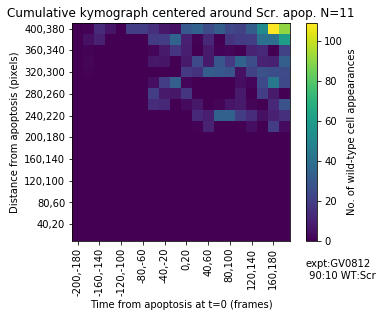

In [209]:
num_bins = 20
H_num_wt, x_autolabels, y_autolabels = np.histogram2d( distance,time, bins=[time_bin_edges,distance_bin_edges])
#H = H/bin_size ### because for every bin each cell could be counted for every frame present. Instead of reducing the count down to any instance of a cell, I want to preserve this cumulative count inside a single bin as a measure for how present that cell is in any bin. Ie a cell that is fully present will be counted fully, but only a fleeting presence of 1/20 frames will count as 1/20th of a fully presence. 
#H_num_wt[0,19] =20000 check the order of time, distance
xlocs, xlabels, ylocs, ylabels = kymo_labels(num_bins, label_freq = int(num_bins*0.1)) ## 0.1 only adds ten labels to the kymograph
plt.xlabel("Time from apoptosis at t=0 (frames)")
plt.ylabel("Distance from apoptosis (pixels)")
title = 'Cumulative kymograph centered around Scr. apop. N=' + str(N_cell)
plt.title(title)
plt.imshow(np.flipud(H_num_wt))
plt.yticks(ylocs, ylabels)
plt.xticks(xlocs, xlabels, rotation='vertical')
plt.colorbar(label = 'No. of wild-type cell appearances')#, ticks = list(range(0, int(round(np.amax(H))),30)))
expt_label = 'expt:' + expt_path[36:42] + '\n 90:10 WT:Scr'
plt.text(21,23,expt_label)
save_title = 'Cumulative_kymo_no._wt.png'
plt.savefig(os.path.join(expt_path, 'analysis', save_title), bbox_inches = 'tight', dpi = 300)

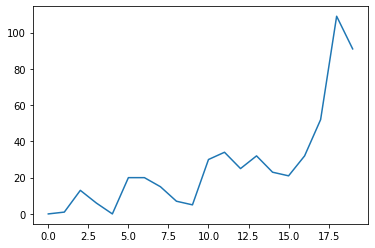

In [210]:
plt.plot(H_num_wt[19,:])

(array([  491.,  1997.,  2528.,  4536.,  6142.,  9835., 15317., 34705.,
        51747., 50494.]),
 array([ 35. , 130.2, 225.4, 320.6, 415.8, 511. , 606.2, 701.4, 796.6,
        891.8, 987. ]),
 <a list of 10 Patch objects>)

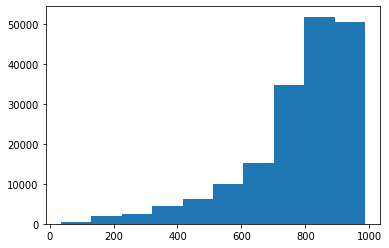

In [194]:
plt.hist(time)

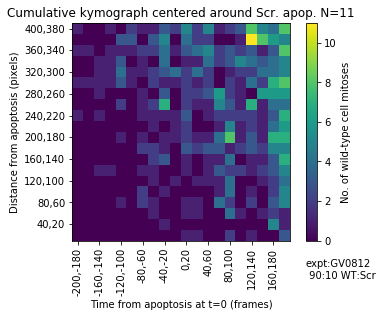

In [211]:
num_bins = 20
H_num_mito, x_autolabels, y_autolabels = np.histogram2d(distance_mito, time_mito,bins=num_bins)
#H_mito = H_mito/bin_size ### because for every bin each cell could be counted for every frame present. Instead of reducing the count down to any instance of a cell, I want to preserve this cumulative count inside a single bin as a measure for how present that cell is in any bin. Ie a cell that is fully present will be counted fully, but only a fleeting presence of 1/20 frames will count as 1/20th of a fully presence. 
xlocs, xlabels, ylocs, ylabels = kymo_labels(num_bins, label_freq = int(num_bins*0.1)) ## 0.1 only adds ten labels to the kymograph
plt.xlabel("Time from apoptosis at t=0 (frames)")
plt.ylabel("Distance from apoptosis (pixels)")
title = 'Cumulative kymograph centered around Scr. apop. N=' + str(N_cell)
plt.title(title)
plt.imshow(np.flipud(H_num_mito))
plt.yticks(ylocs, ylabels)
plt.xticks(xlocs, xlabels, rotation='vertical')
plt.colorbar(label = 'No. of wild-type cell mitoses')#, ticks = list(range(0, int(round(np.amax(H_mito))),2)))
expt_label = 'expt:' + expt_path[36:42] + '\n 90:10 WT:Scr'
plt.text(21,23,expt_label)
save_title = 'Cumulative_kymo_no._wt_mito.png'
plt.savefig(os.path.join(expt_path, 'analysis', save_title), bbox_inches = 'tight', dpi = 300)

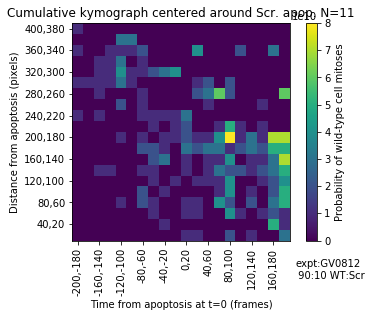

In [215]:
num_bins = 20
H_prob_mito  = H_num_mito/(H_num_wt+1E-10)
xlocs, xlabels, ylocs, ylabels = kymo_labels(num_bins, label_freq = int(num_bins*0.1)) ## 0.1 only adds ten labels to the kymograph
plt.xlabel("Time from apoptosis at t=0 (frames)")
plt.ylabel("Distance from apoptosis (pixels)")
title = 'Cumulative kymograph centered around Scr. apop. N=' + str(N_cell)
plt.title(title)
plt.imshow(np.flipud(H_prob_mito))
plt.yticks(ylocs, ylabels)
plt.xticks(xlocs, xlabels, rotation='vertical')
plt.colorbar(label = 'Probability of wild-type cell mitoses')
expt_label = 'expt:' + expt_path[36:42] + '\n 90:10 WT:Scr'
plt.text(20,23,expt_label)
save_title = 'Cumulative_kymo_prob_wt_mito.png'
plt.savefig(os.path.join(expt_path, 'analysis', save_title), bbox_inches = 'tight', dpi = 300)